# 實體嵌入具體操作方式(Entity_Embedding)

In [116]:
# 相關套件載入
import pandas as pd
import numpy as np
import random as rn
import pydotplus # 繪製tensflow圖
import graphviz # 繪製tensflow圖

from sklearn.preprocessing import StandardScaler


from tensorflow.keras.layers import Embedding, Dropout, Input, Dense, Reshape, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

In [2]:
# 讀取資料-以銀行業為例
BankDf = pd.read_excel('C:/Users/hsu/Desktop/bank.xlsx')
df = BankDf.copy()

# 特徵定義

RowNumber：行號，這個肯定沒用，刪除

CustomerID：用戶編號，這個是順序發放的，刪除

Surname：用戶姓名，對流失沒有影響，刪除

CreditScore：信用分數，這個很重要，保留

Geography：用戶所在國家/地區，這個有影響，保留

Gender：用戶性別，可能有影響，保留

Age：年齡，影響很大，年輕人更容易切換銀行，保留

Tenure：當了本銀行多少年用戶，很重要，保留

Balance：存貸款情況，很重要，保留

NumOfProducts：使用產品數量，很重要，保留

HasCrCard：是否有本行信用卡，很重要，保留

IsActiveMember：是否活躍用戶，很重要，保留

EstimatedSalary：估計收入，很重要，保留

Exited：是否已流失，這將作為我們的標籤數據

原文網址：https://kknews.cc/career/y2pe3kj.html

In [6]:
# 資料探索
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [101]:
# 前三欄特徵可拋棄(行號、用戶編號、用戶姓名)
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [104]:
# 資料重新探索
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [108]:
# 類別型特徵放於前四個位置，之後放置數值特徵，最後為目標變數(此舉在於方便寫作嵌入函數)
df =  df[['Geography','Gender','HasCrCard','IsActiveMember',
          'Age', 'Tenure', 'NumOfProducts','CreditScore','Balance', 'EstimatedSalary',
          'Exited']]

In [115]:
# 將不同資料型態特徵取出處理

dfc = df.iloc[:,0:4] # 類別特徵：將其轉為EE函數可放置資料結構
dfn = df.iloc[:,4:-1] # 數值資料：將其標準化，降低數值過大干擾
dfy = df[['Exited']] # 目標變數

In [126]:
# 類別特徵：轉為數值格式(0、1、2、…)
dfc['Geography'] = dfc['Geography'].replace({'France':0, 'Germany':1, 'Spain':2})
dfc['Gender'] = dfc['Gender'].replace({'Female':0, 'Male':1})

# 以上二類別特徵已為0、1格式，故不用轉換
# dfc['HasCrCard']
# dfc['IsActiveMember']

In [127]:
# 數值資料：標準化處理
sc = StandardScaler()
dfn = pd.DataFrame(sc.fit_transform(dfn), columns=dfn.columns)

In [132]:
# 再將資料處理完成的dataframe合為完整資料集
df = pd.concat([dfc, dfn, dfy], axis = 1)
df.to_excel('C:/Users/hsu/Desktop/ADBank.xlsx', index = False)

# Data Transform for EntityEmbedding and Build EE fun

In [134]:
df.head()

,Geography,Gender,HasCrCard,IsActiveMember,Age,Tenure,NumOfProducts,CreditScore,Balance,EstimatedSalary,Exited
0,0,0,1,1,0.293517,-1.041760,-0.911583,-0.326221,-1.225848,0.021886,1
1,2,0,0,1,0.198164,-1.387538,-0.911583,-0.440036,0.117350,0.216534,0
2,0,0,1,0,0.293517,1.032908,2.527057,-1.536794,1.333053,0.240687,1
3,0,0,0,0,0.007457,-1.387538,0.807737,0.501521,-1.225848,-0.108918,0
4,2,0,1,1,0.388871,-1.041760,-0.911583,2.063884,0.785728,-0.365276,0


In [161]:
# 所有特徵轉換EE格式
ex = []
for i in df.iloc[:,:-1].columns:
    f = np.array([i for i in df[i]]).reshape(10000, 1)
    ex.append(f)

In [162]:
# 目標變數轉換EE格式
ey = np.array([i for i in df['Exited']]).reshape(10000, 1)

In [163]:
# 撰寫EE運作函數
sample_num = 10000 # 觀察值為32
cate_feature_num = 4 # 類別特徵 4
contious_feature_num = 6 # 數值特徵 6
cate_embedding_dimension = {'0':5, '1':3, '2':3, '3':3} # EE轉換後特徵
 
def build_embedding_network():
 
    '''
    通常寫法會將dataframe資料調整，將類別變數放置dataframe前面位置
    ''' 
    
    inputs = []
    embeddings = []
    
    ### 所有dataframe的特徵都需寫進行E.E中，一個資料集如有3個欄位(2個類別特徵，1個數值特徵)
    ### 就必須寫3次。通常為了後續容易了解，我們先將類別的向量嵌入寫在前面，
    ### 而且需增加Embedding嵌入資料，再用Reshape拉直。
    ### 數值資料只需增加Dense
    
    input_cate_feature_1 = Input(shape=(1,))
    embedding = Embedding(3, 5, input_length=1)(input_cate_feature_1) # name可以命名該層名稱
    # embedding後是10*1*3，為了後續计算方便，因此使用Reshape轉為10*3(易使後續concat)
    embedding = Reshape(target_shape=(5,))(embedding)
    inputs.append(input_cate_feature_1)
    embeddings.append(embedding)
    
    input_cate_feature_2 = Input(shape=(1,))
    embedding = Embedding(2, 3, input_length=1)(input_cate_feature_2)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_cate_feature_2)
    embeddings.append(embedding)
    
    input_cate_feature_3 = Input(shape=(1,))
    embedding = Embedding(2, 3, input_length=1)(input_cate_feature_3)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_cate_feature_3)
    embeddings.append(embedding)
    
    input_cate_feature_4 = Input(shape=(1,))
    embedding = Embedding(2, 3, input_length=1)(input_cate_feature_4)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_cate_feature_4)
    embeddings.append(embedding)
    
    input_numeric1 = Input(shape=(1,))
    embedding_numeric = Dense(1)(input_numeric1) 
    inputs.append(input_numeric1)
    embeddings.append(embedding_numeric)
    
    input_numeric2 = Input(shape=(1,))
    embedding_numeric = Dense(1)(input_numeric2) 
    inputs.append(input_numeric2)
    embeddings.append(embedding_numeric)
    
    input_numeric3 = Input(shape=(1,))
    embedding_numeric = Dense(1)(input_numeric3) 
    inputs.append(input_numeric3)
    embeddings.append(embedding_numeric)
    
    input_numeric4 = Input(shape=(1,))
    embedding_numeric = Dense(1)(input_numeric4) 
    inputs.append(input_numeric4)
    embeddings.append(embedding_numeric)
    
    input_numeric5 = Input(shape=(1,))
    embedding_numeric = Dense(1)(input_numeric5) 
    inputs.append(input_numeric5)
    embeddings.append(embedding_numeric)
    
    input_numeric6 = Input(shape=(1,))
    embedding_numeric = Dense(1)(input_numeric6) 
    inputs.append(input_numeric6)
    embeddings.append(embedding_numeric)
       
     
    # 此一過程，再於將所有嵌入後的類別資料以及數值資料(不需調整)，拉成一條
    x = Concatenate()(embeddings)
    
    # 經過二層Dense
    x = Dense(10, activation='tanh')(x)
    #x = Dropout(.15)(x)
    x = Dense(10, activation='tanh')(x)
    #x = Dropout(.15)(x)
    
    # 最後進行output輸出
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, output)
 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
    return model

In [165]:
# 訓練模型
NN = build_embedding_network()
NN.fit(ex, ey, epochs=50, batch_size=100, verbose=1)

Train on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 0s 23us/sample - loss: 0.3275 - accuracy: 0.8644
Epoch 2/50
10000/10000 [==============================] - 0s 21us/sample - loss: 0.3274 - accuracy: 0.8644
Epoch 3/50
10000/10000 [==============================] - 0s 23us/sample - loss: 0.3272 - accuracy: 0.8635
Epoch 4/50
10000/10000 [==============================] - 0s 23us/sample - loss: 0.3269 - accuracy: 0.8630
Epoch 5/50
10000/10000 [==============================] - 0s 24us/sample - loss: 0.3266 - accuracy: 0.8644
Epoch 6/50
10000/10000 [==============================] - 0s 24us/sample - loss: 0.3271 - accuracy: 0.8644
Epoch 7/50
10000/10000 [==============================] - 0s 31us/sample - loss: 0.3264 - accuracy: 0.8656
Epoch 8/50
10000/10000 [==============================] - 0s 35us/sample - loss: 0.3266 - accuracy: 0.8631
Epoch 9/50
10000/10000 [==============================] - 0s 24us/sample - loss: 0.3266 - accuracy: 0.8646
Epoch 10/50
10

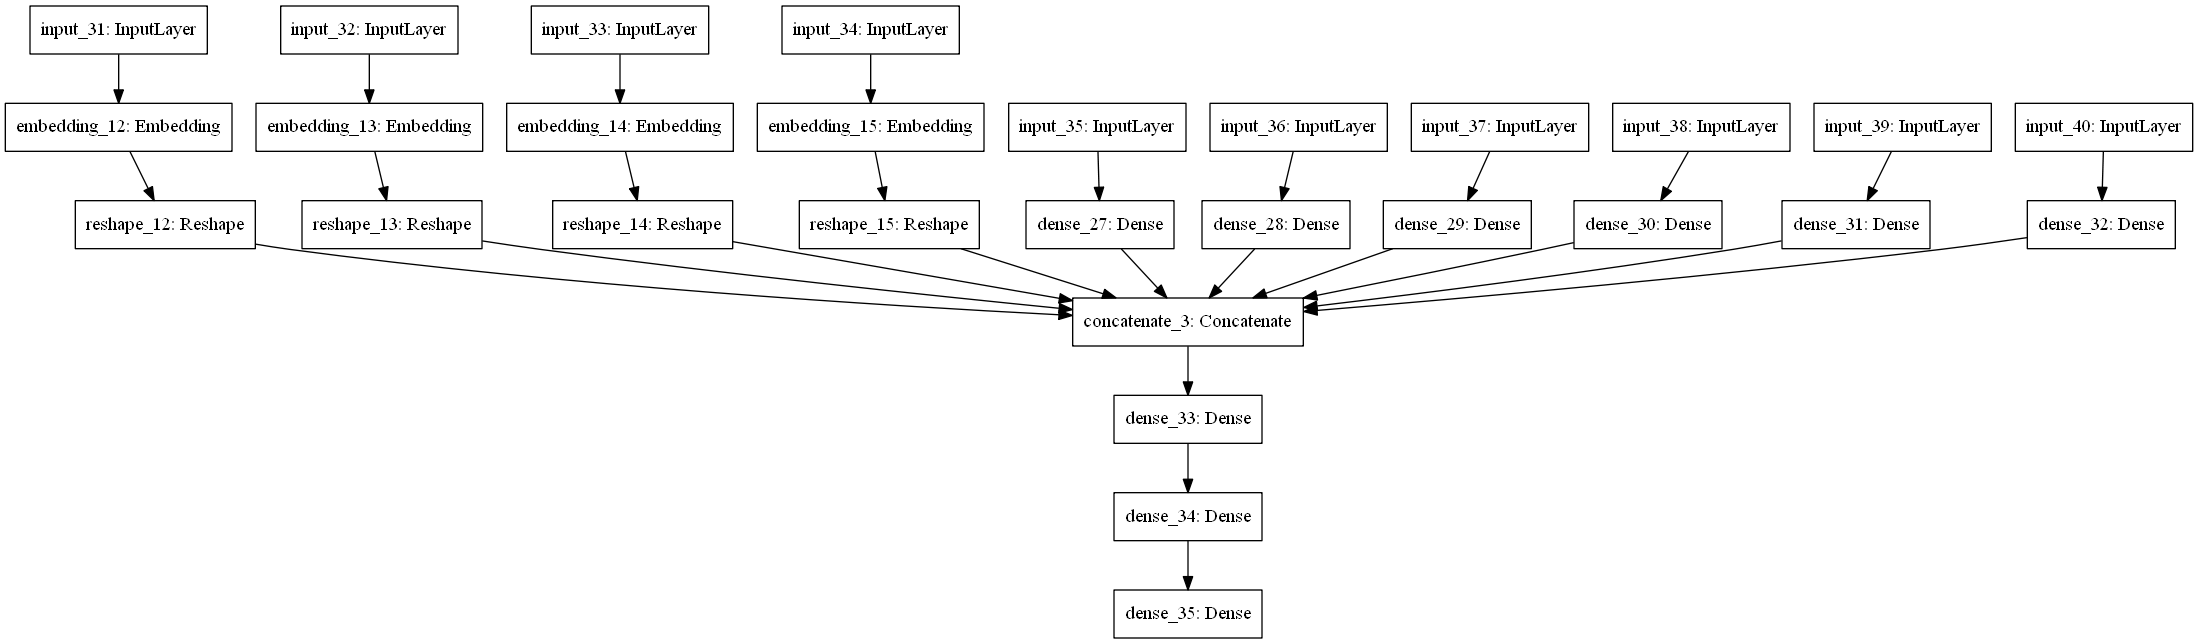

In [166]:
# 輸出EE張量
#import graphviz
#import pydotplus

from tensorflow.keras.utils import plot_model
plot_model(NN, to_file='NN.png', show_layer_names=True)
# plot_model(NN, to_file='NN.png', show_shapes=True, show_layer_names=True) 完整寫法

In [167]:
# 取出嵌入向量資料

model = NN  # 將訓練完成的模型存成物件
for i in range(cate_feature_num):
    # 由NN.png圖可知，如果把類別特徵放置在前、連續特徵放於後，cate_feature_num+i就是所有embedding層
    layer_name = NN.get_config()['layers'][cate_feature_num+i]['name']
 
    intermediate_layer_model = Model(inputs=NN.input,
                                     outputs=model.get_layer(layer_name).output)
    
    # numpy.array
    intermediate_output = intermediate_layer_model.predict(ex)
    
    intermediate_output.resize([10000,cate_embedding_dimension[str(i)]])
    
    if i == 0:
        X_embedding_trans = intermediate_output
    else:
        X_embedding_trans = np.hstack((X_embedding_trans,intermediate_output)) #水平拼接
    

# 取出原來的數值特徵
for i in range(contious_feature_num):
    if i == 0:
        X_contious = ex[cate_feature_num+i]
    else:
        X_contious = np.hstack((X_contious,ex[cate_feature_num+i]))

In [172]:
pd.concat(BankEE,df[['Exited']], axis = 1)

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [174]:
# 將實體嵌入(EE)資料與原先數值資料合為dataframe資料格式
X_trans = np.hstack((X_embedding_trans,X_contious))
BankEE = pd.DataFrame(X_trans)
BankEE = pd.concat([BankEE, df[['Exited']]], axis = 1) # 將原先的目標變數移回來，使其為完整資料集

In [175]:
BankEE.to_excel('C:/Users/hsu/Desktop/BankEE.xlsx', index=False)

In [178]:
BankEE.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Exited
0,0.138610,0.160695,-0.277173,0.060637,-0.180083,0.040039,-0.075394,-0.041599,0.022179,0.290111,...,-0.241361,-0.160749,-0.452690,0.293517,-1.041760,-0.911583,-0.326221,-1.225848,0.021886,1
1,0.091419,0.097679,-0.210435,0.527534,-0.158492,0.040039,-0.075394,-0.041599,0.148332,0.119614,...,-0.241361,-0.160749,-0.452690,0.198164,-1.387538,-0.911583,-0.440036,0.117350,0.216534,0
2,0.138610,0.160695,-0.277173,0.060637,-0.180083,0.040039,-0.075394,-0.041599,0.022179,0.290111,...,0.202704,0.069410,0.193958,0.293517,1.032908,2.527057,-1.536794,1.333053,0.240687,1
3,0.138610,0.160695,-0.277173,0.060637,-0.180083,0.040039,-0.075394,-0.041599,0.148332,0.119614,...,0.202704,0.069410,0.193958,0.007457,-1.387538,0.807737,0.501521,-1.225848,-0.108918,0
4,0.091419,0.097679,-0.210435,0.527534,-0.158492,0.040039,-0.075394,-0.041599,0.022179,0.290111,...,-0.241361,-0.160749,-0.452690,0.388871,-1.041760,-0.911583,2.063884,0.785728,-0.365276,0


# 資料分析

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [183]:
X = BankEE.drop('Exited', axis = 1)
y = BankEE['Exited']

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [185]:
X_train.shape

(7000, 20)

In [232]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Dense(units = 10, activation='relu', input_dim = 20))
model.add(Dense(units = 10, activation='relu', activity_regularizer=l2(l =0.01)))
model.add(Dense(units = 2, activation='softmax'))

In [233]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
lossS = SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer = 'adam',
              loss = lossS,
              metrics = ['accuracy'])


In [234]:
history = model.fit(X_train, y_train,
                    batch_size = 50,
                    epochs = 100,
                    validation_data = (X_test, y_test),
                    verbose = 1)

Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 0s 46us/sample - loss: 0.5704 - accuracy: 0.7946 - val_loss: 0.5425 - val_accuracy: 0.7963
Epoch 2/100
7000/7000 [==============================] - 0s 30us/sample - loss: 0.5339 - accuracy: 0.7963 - val_loss: 0.5286 - val_accuracy: 0.7963
Epoch 3/100
7000/7000 [==============================] - 0s 30us/sample - loss: 0.5223 - accuracy: 0.7963 - val_loss: 0.5199 - val_accuracy: 0.7963
Epoch 4/100
7000/7000 [==============================] - 0s 27us/sample - loss: 0.5144 - accuracy: 0.7963 - val_loss: 0.5137 - val_accuracy: 0.7963
Epoch 5/100
7000/7000 [==============================] - 0s 31us/sample - loss: 0.5084 - accuracy: 0.7970 - val_loss: 0.5094 - val_accuracy: 0.8017
Epoch 6/100
7000/7000 [==============================] - 0s 32us/sample - loss: 0.5035 - accuracy: 0.8037 - val_loss: 0.5047 - val_accuracy: 0.8070
Epoch 7/100
7000/7000 [==============================] - 0s 30us

7000/7000 [==============================] - 0s 33us/sample - loss: 0.4453 - accuracy: 0.8709 - val_loss: 0.4559 - val_accuracy: 0.8557
Epoch 55/100
7000/7000 [==============================] - 0s 27us/sample - loss: 0.4451 - accuracy: 0.8706 - val_loss: 0.4561 - val_accuracy: 0.8557
Epoch 56/100
7000/7000 [==============================] - 0s 29us/sample - loss: 0.4453 - accuracy: 0.8714 - val_loss: 0.4563 - val_accuracy: 0.8560
Epoch 57/100
7000/7000 [==============================] - 0s 27us/sample - loss: 0.4451 - accuracy: 0.8714 - val_loss: 0.4556 - val_accuracy: 0.8567
Epoch 58/100
7000/7000 [==============================] - 0s 30us/sample - loss: 0.4447 - accuracy: 0.8704 - val_loss: 0.4563 - val_accuracy: 0.8540
Epoch 59/100
7000/7000 [==============================] - 0s 33us/sample - loss: 0.4448 - accuracy: 0.8730 - val_loss: 0.4557 - val_accuracy: 0.8553
Epoch 60/100
7000/7000 [==============================] - 0s 27us/sample - loss: 0.4448 - accuracy: 0.8706 - val_loss: 

In [235]:
y_pred = model.predict(X_test)

In [236]:
y_pred2 = np.argmax(y_pred, axis = 1)

In [237]:
confusion_matrix(y_test, y_pred2)

array([[2277,  112],
       [ 321,  290]], dtype=int64)

In [238]:
f1_score(y_test, y_pred2)

0.5725567620927937

In [239]:
from sklearn.ensemble import RandomForestClassifier

In [253]:
rfclf = RandomForestClassifier(n_estimators=500, criterion='gini')

In [254]:
rfclf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [255]:
y_pred3 = rfclf.predict(X_test)

In [256]:
accuracy_score(y_test, y_pred3)

0.8613333333333333

In [257]:
confusion_matrix(y_test, y_pred3)

array([[2293,   96],
       [ 320,  291]], dtype=int64)

In [258]:
f1_score(y_test, y_pred3)

0.5831663326653307